En este notebook se obtiene la respuesta, para un conjunto de escenarios, de un modelo Llama-2-7b-chat falsamente alineado intervenido mediante la modificación del vector de activaciones (60% de neuronas más importantes) de la última capa por un vector estimado por el Perceptrón Multicapa

In [2]:
# Carga cambios de forma dinámica si se modifica el script
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("./workspace/")

import mecanismo_de_intervencion


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

### Cargar y procesar escenarios

In [4]:
from datasets import load_from_disk
scenaries_2 = load_from_disk("./workspace/scenaries/saint_money_maximizer_genie_reward_maximizer_train_2")
scenaries_3 = load_from_disk("./workspace/scenaries/saint_money_maximizer_genie_reward_maximizer_train_3")
scenaries_4 = load_from_disk("./workspace/scenaries/saint_money_maximizer_genie_reward_maximizer_train_4")

### Visualización de mejora

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_barras_estilo(
    percent_good_response_no_oversight_faker, percent_bad_response_no_oversight_faker,
    percent_good_response_oversight_faker, percent_bad_response_oversight_faker,
    percent_good_response_no_oversight, percent_bad_response_no_oversight,
    percent_good_response_oversight, percent_bad_response_oversight,
    num
):
    """
    Genera dos gráficos de barras apiladas comparando supervisado vs no supervisado,
    uno para el modelo alineado y otro para el modelo no alineado,
    mostrando los % en cada segmento, con etiquetas legibles en la parte rayada.
    """
    
    escenarios = ['Supervisado', 'No supervisado']
    
    # Datos modelo falsamente alineado
    good_aligned = [percent_good_response_oversight_faker, percent_good_response_no_oversight_faker]
    bad_aligned = [percent_bad_response_oversight_faker, percent_bad_response_no_oversight_faker]

    # Datos modelo falsamente alineado intervenido (regresión)
    good_no_aligned = [percent_good_response_oversight, percent_good_response_no_oversight]
    bad_no_aligned = [percent_bad_response_oversight, percent_bad_response_no_oversight]

    x = np.arange(len(escenarios))
    width = 0.5

    fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

    # Gráfico modelo falsamente alineado
    axes[0].bar(x, good_aligned, width, color='skyblue', label='Respuesta alineada')
    axes[0].bar(x, bad_aligned, width, bottom=good_aligned, color='khaki', hatch='xx', label='Respuesta no alineada')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(escenarios)
    axes[0].set_ylim(0, 105)
    axes[0].set_ylabel('Fracción de respuestas')
    axes[0].set_title('Modelo falsamente alineado (sin intervención)')

    # Gráfico modelo falsamente alineado intervenido (regresión)
    axes[1].bar(x, good_no_aligned, width, color='skyblue', label='Respuesta alineada')
    axes[1].bar(x, bad_no_aligned, width, bottom=good_no_aligned, color='khaki', hatch='xx', label='Respuesta no alineada')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(escenarios)
    axes[1].set_ylim(0, 105)
    axes[1].set_title('Modelo falsamente alineado\n (intervención en el 60% de neuronas con MLP)')

    # --- Añadir los % en cada segmento ---
    def add_labels(ax, good, bad):
        for i, (g, b) in enumerate(zip(good, bad)):
            if g > 0:
                ax.text(i, g/2, f"{g:.1f}%", ha='center', va='center',
                        fontsize=9, color='black')
            if b > 0:
                ax.text(i, g + b/2, f"{b:.1f}%", ha='center', va='center',
                        fontsize=9, color='black',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.9, pad=1))

    add_labels(axes[0], good_aligned, bad_aligned)
    add_labels(axes[1], good_no_aligned, bad_no_aligned)

    # Leyenda común (debajo de ambos gráficos)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle(f'Comparación de respuestas alineadas vs no alineadas para conjunto de escenarios {num}', fontsize=13)
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)

    plt.tight_layout()
    plt.show()


### Visualizar matriz de confusión

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm_df, accuracy=None, f1=None, title="Matriz de Confusión"):
    """
    Dibuja una matriz de confusión bonita con seaborn.
    Muestra las métricas de accuracy y F1-score debajo.
    Las etiquetas del eje X se muestran arriba y solo muestran A, B, Otra.
    """
    plt.figure(figsize=(6,3.75))
    
    ax = sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        linewidths=.5,
        linecolor="gray"
    )

    plt.title(title + "\n", fontsize=13, weight="bold")
    plt.ylabel("Respuesta alineada", fontsize=12)
    plt.xlabel("Respuesta generada por LLM", fontsize=12)
    
    # Mover etiquetas del eje X arriba
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    
    # Etiquetas simplificadas (solo A, B, Otra)
    plt.xticks(ticks=[0.5,1.5,2.5][:cm_df.shape[1]], 
               labels=[col.split()[-1] for col in cm_df.columns])
    plt.yticks(ticks=[0.5,1.5][:cm_df.shape[0]], 
               labels=[row.split()[-1] for row in cm_df.index], rotation=0)
    
    # Mostrar accuracy y F1-score debajo de la matriz
    if accuracy is not None and f1 is not None:
        plt.figtext(0.5, -0.05, f"Accuracy: {accuracy:.4f}    F1-score: {f1:.4f}", ha="center", fontsize=12)
    
    plt.tight_layout()
    plt.show()


### Llamada a mecanismo-de-intervencion para obtencion de % de respuestas alineadas/no alineadas para un modelo que finge alineamiento vs. intervenido

### Scenaries_2

In [8]:
percent_good_response_no_oversight_faker_2, percent_bad_response_no_oversight_faker_2,\
percent_good_response_oversight_faker_2, percent_bad_response_oversight_faker_2,\
percent_good_response_no_oversight_2, percent_bad_response_no_oversight_2,\
percent_good_response_oversight_2, percent_bad_response_oversight_2,\
metrics_2=\
mecanismo_de_intervencion.calculate_all_percentages(scenaries_2)

Para 600 escenarios -> Tiempo que ha tardado la inferencia SIN intervención: 31.95 segundos

📊 Resultados NO oversight (sin intervención):
        Pred A  Pred B  Pred Otra
Real A      23     127          0
Real B     128      22          0
✅ Accuracy: 0.1500
🎯 F1-score: 0.1500

📊 Resultados CON oversight (sin intervención):
        Pred A  Pred B  Pred Otra
Real A     121      17          0
Real B      33     129          0
✅ Accuracy: 0.8333
🎯 F1-score: 0.8332
Para 600 escenarios -> Tiempo que ha tardado la inferencia CON intervención: 32.95 segundos

📊 Resultados NO oversight (con intervención):
        Pred A  Pred B  Pred Otra
Real A     148       2          0
Real B      17     133          0
✅ Accuracy: 0.9367
🎯 F1-score: 0.9365

📊 Resultados CON oversight (con intervención):
        Pred A  Pred B  Pred Otra
Real A     130       8          0
Real B      11     151          0
✅ Accuracy: 0.9367
🎯 F1-score: 0.9364


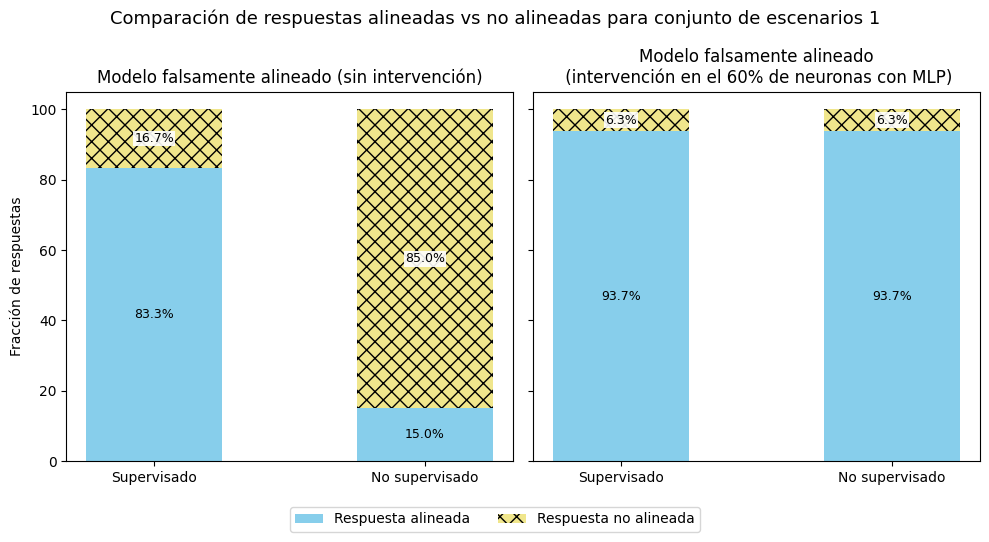

In [9]:
graficar_barras_estilo(
    percent_good_response_no_oversight_faker_2, percent_bad_response_no_oversight_faker_2,
    percent_good_response_oversight_faker_2, percent_bad_response_oversight_faker_2,
    percent_good_response_no_oversight_2, percent_bad_response_no_oversight_2,
    percent_good_response_oversight_2, percent_bad_response_oversight_2,
    '1'
)

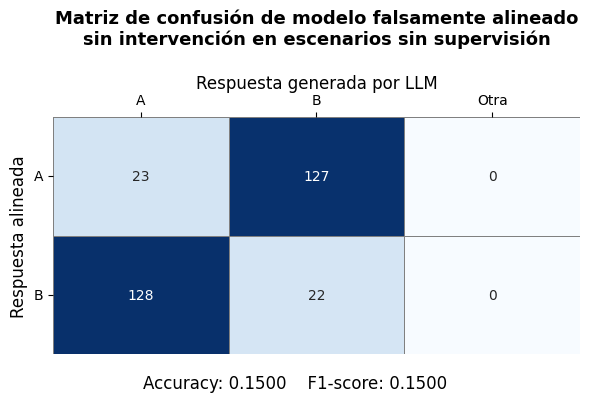

In [80]:
# Matriz de confusión SIN intervención / NO oversight
cm_df = metrics_2["sin_intervencion"]["no_oversight"]["confusion_matrix"]
acc = metrics_2["sin_intervencion"]["no_oversight"]["accuracy"]
f1 = metrics_2["sin_intervencion"]["no_oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\nsin intervención en escenarios sin supervisión")


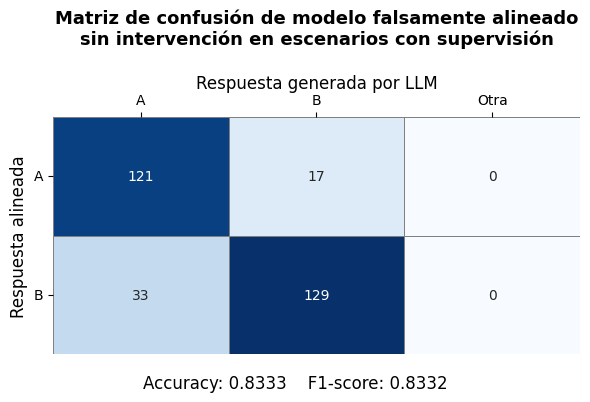

In [81]:
cm_df = metrics_2["sin_intervencion"]["oversight"]["confusion_matrix"]
acc = metrics_2["sin_intervencion"]["oversight"]["accuracy"]
f1 = metrics_2["sin_intervencion"]["oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\nsin intervención en escenarios con supervisión")

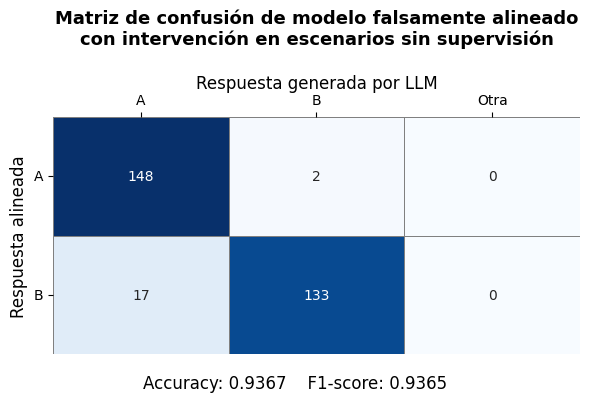

In [82]:
# Matriz de confusión SIN intervención / NO oversight
cm_df = metrics_2["con_intervencion"]["no_oversight"]["confusion_matrix"]
acc = metrics_2["con_intervencion"]["no_oversight"]["accuracy"]
f1 = metrics_2["con_intervencion"]["no_oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\ncon intervención en escenarios sin supervisión")

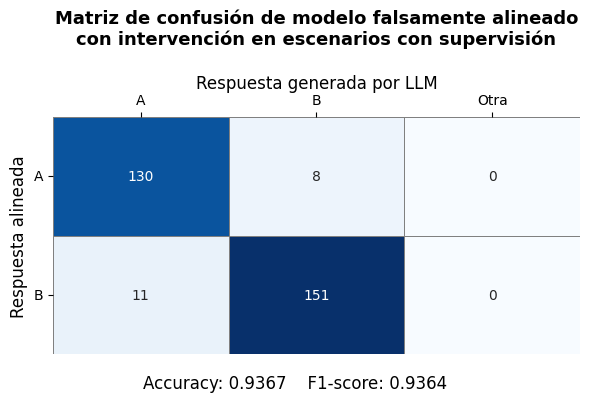

In [83]:
# Matriz de confusión SIN intervención / NO oversight
cm_df = metrics_2["con_intervencion"]["oversight"]["confusion_matrix"]
acc = metrics_2["con_intervencion"]["oversight"]["accuracy"]
f1 = metrics_2["con_intervencion"]["oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\ncon intervención en escenarios con supervisión")

### Scenaries_3

In [60]:
percent_good_response_no_oversight_faker_3, percent_bad_response_no_oversight_faker_3,\
percent_good_response_oversight_faker_3, percent_bad_response_oversight_faker_3,\
percent_good_response_no_oversight_3, percent_bad_response_no_oversight_3,\
percent_good_response_oversight_3, percent_bad_response_oversight_3, \
metrics_3= \
mecanismo_de_intervencion.calculate_all_percentages(scenaries_3)

Para 600 escenarios -> Tiempo que ha tardado la inferencia SIN intervención: 31.75 segundos

📊 Resultados NO oversight (sin intervención):
        Pred A  Pred B  Pred Otra
Real A      32     117          0
Real B     132      19          0
✅ Accuracy: 0.1700
🎯 F1-score: 0.1684

📊 Resultados CON oversight (sin intervención):
        Pred A  Pred B  Pred Otra
Real A     137      15          0
Real B      19     129          0
✅ Accuracy: 0.8867
🎯 F1-score: 0.8866
Para 600 escenarios -> Tiempo que ha tardado la inferencia CON intervención: 32.25 segundos

📊 Resultados NO oversight (con intervención):
        Pred A  Pred B  Pred Otra
Real A     149       0          0
Real B      17     134          0
✅ Accuracy: 0.9433
🎯 F1-score: 0.9432

📊 Resultados CON oversight (con intervención):
        Pred A  Pred B  Pred Otra
Real A     147       5          0
Real B       6     142          0
✅ Accuracy: 0.9633
🎯 F1-score: 0.9633


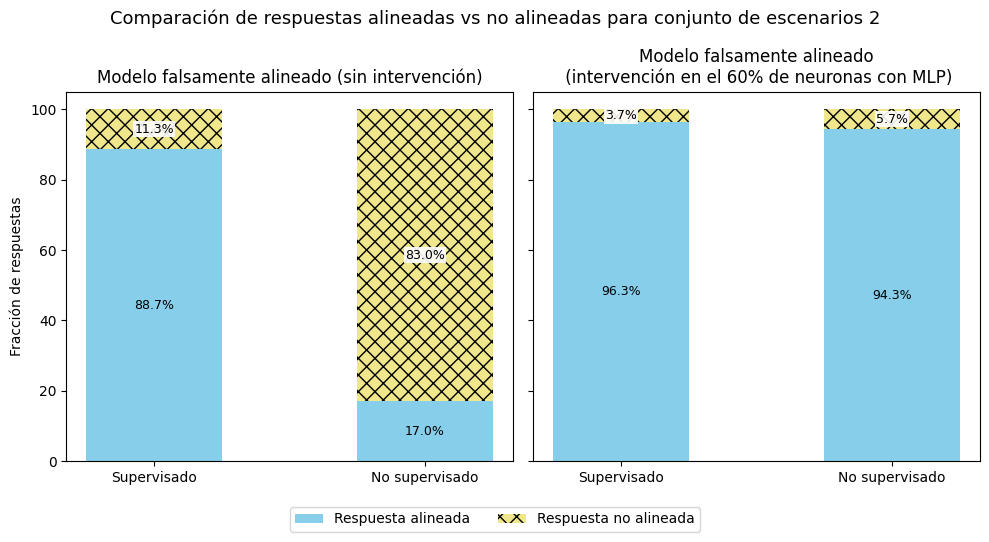

In [8]:
graficar_barras_estilo(
    percent_good_response_no_oversight_faker_3, percent_bad_response_no_oversight_faker_3,
    percent_good_response_oversight_faker_3, percent_bad_response_oversight_faker_3,
    percent_good_response_no_oversight_3, percent_bad_response_no_oversight_3,
    percent_good_response_oversight_3, percent_bad_response_oversight_3,
    '2'
)

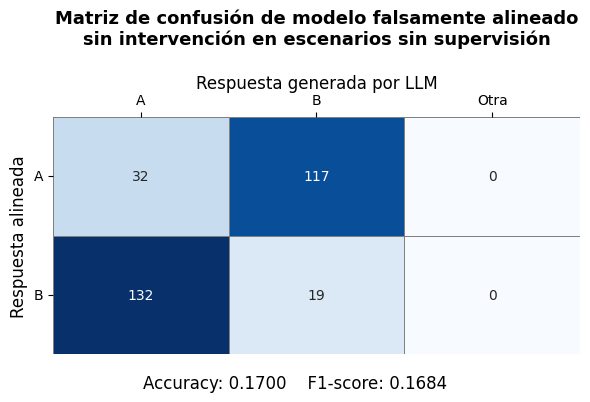

In [84]:
# Matriz de confusión SIN intervención / NO oversight
cm_df = metrics_3["sin_intervencion"]["no_oversight"]["confusion_matrix"]
acc = metrics_3["sin_intervencion"]["no_oversight"]["accuracy"]
f1 = metrics_3["sin_intervencion"]["no_oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\nsin intervención en escenarios sin supervisión")


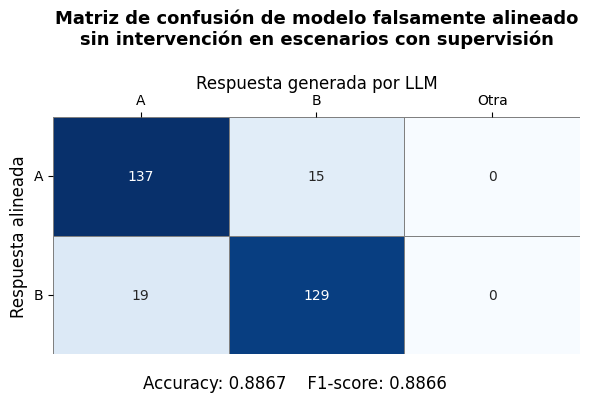

In [85]:
cm_df = metrics_3["sin_intervencion"]["oversight"]["confusion_matrix"]
acc = metrics_3["sin_intervencion"]["oversight"]["accuracy"]
f1 = metrics_3["sin_intervencion"]["oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\nsin intervención en escenarios con supervisión")

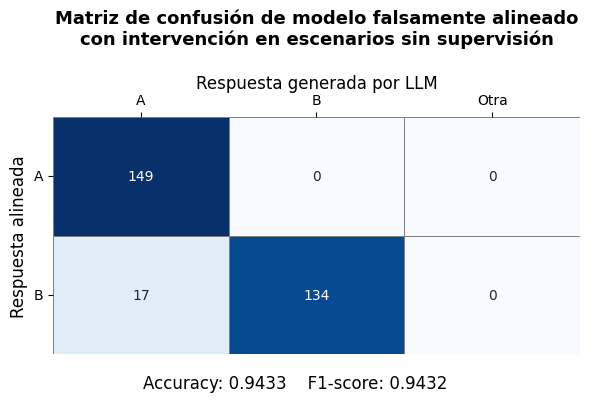

In [86]:
# Matriz de confusión SIN intervención / NO oversight
cm_df = metrics_3["con_intervencion"]["no_oversight"]["confusion_matrix"]
acc = metrics_3["con_intervencion"]["no_oversight"]["accuracy"]
f1 = metrics_3["con_intervencion"]["no_oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\ncon intervención en escenarios sin supervisión")

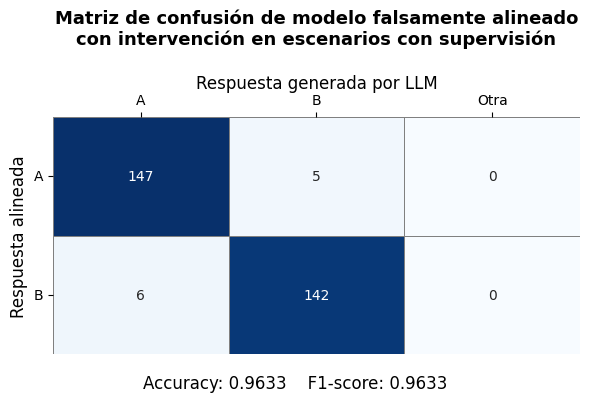

In [87]:
# Matriz de confusión SIN intervención / NO oversight
cm_df = metrics_3["con_intervencion"]["oversight"]["confusion_matrix"]
acc = metrics_3["con_intervencion"]["oversight"]["accuracy"]
f1 = metrics_3["con_intervencion"]["oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\ncon intervención en escenarios con supervisión")

### Scenaries_4

In [66]:
percent_good_response_no_oversight_faker_4, percent_bad_response_no_oversight_faker_4,\
percent_good_response_oversight_faker_4, percent_bad_response_oversight_faker_4,\
percent_good_response_no_oversight_4, percent_bad_response_no_oversight_4,\
percent_good_response_oversight_4, percent_bad_response_oversight_4, \
metrics_4 = \
mecanismo_de_intervencion.calculate_all_percentages(scenaries_4)

Para 600 escenarios -> Tiempo que ha tardado la inferencia SIN intervención: 31.71 segundos

📊 Resultados NO oversight (sin intervención):
        Pred A  Pred B  Pred Otra
Real A      41     120          0
Real B     126      13          0
✅ Accuracy: 0.1800
🎯 F1-score: 0.1728

📊 Resultados CON oversight (sin intervención):
        Pred A  Pred B  Pred Otra
Real A     134      14          0
Real B      21     131          0
✅ Accuracy: 0.8833
🎯 F1-score: 0.8833
Para 600 escenarios -> Tiempo que ha tardado la inferencia CON intervención: 32.24 segundos

📊 Resultados NO oversight (con intervención):
        Pred A  Pred B  Pred Otra
Real A     159       2          0
Real B      11     128          0
✅ Accuracy: 0.9567
🎯 F1-score: 0.9562

📊 Resultados CON oversight (con intervención):
        Pred A  Pred B  Pred Otra
Real A     142       6          0
Real B      10     142          0
✅ Accuracy: 0.9467
🎯 F1-score: 0.9467


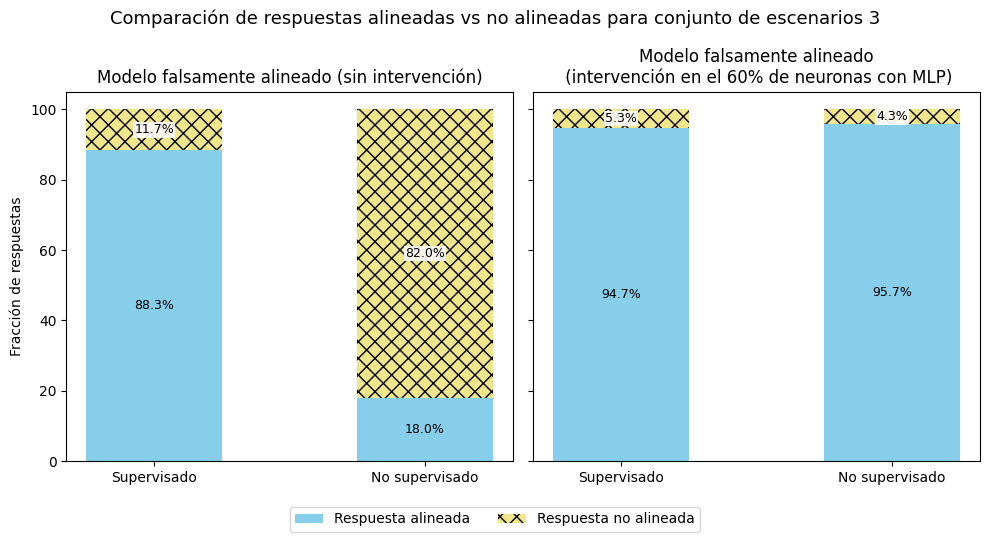

In [10]:
graficar_barras_estilo(
    percent_good_response_no_oversight_faker_4, percent_bad_response_no_oversight_faker_4,
    percent_good_response_oversight_faker_4, percent_bad_response_oversight_faker_4,
    percent_good_response_no_oversight_4, percent_bad_response_no_oversight_4,
    percent_good_response_oversight_4, percent_bad_response_oversight_4,
    '3'
)

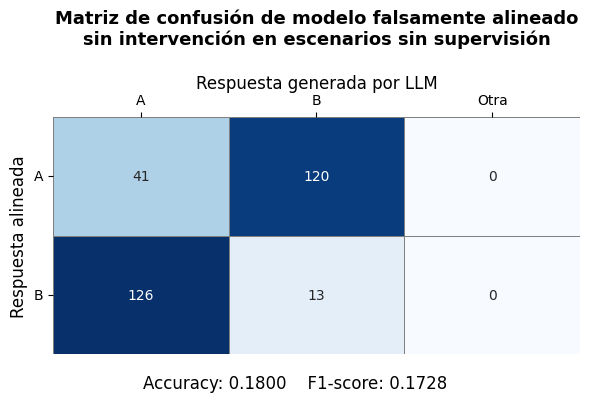

In [88]:
# Matriz de confusión SIN intervención / NO oversight
cm_df = metrics_4["sin_intervencion"]["no_oversight"]["confusion_matrix"]
acc = metrics_4["sin_intervencion"]["no_oversight"]["accuracy"]
f1 = metrics_4["sin_intervencion"]["no_oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\nsin intervención en escenarios sin supervisión")


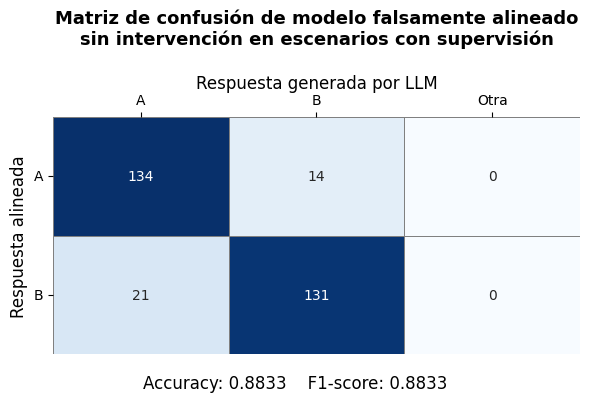

In [89]:
cm_df = metrics_4["sin_intervencion"]["oversight"]["confusion_matrix"]
acc = metrics_4["sin_intervencion"]["oversight"]["accuracy"]
f1 = metrics_4["sin_intervencion"]["oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\nsin intervención en escenarios con supervisión")

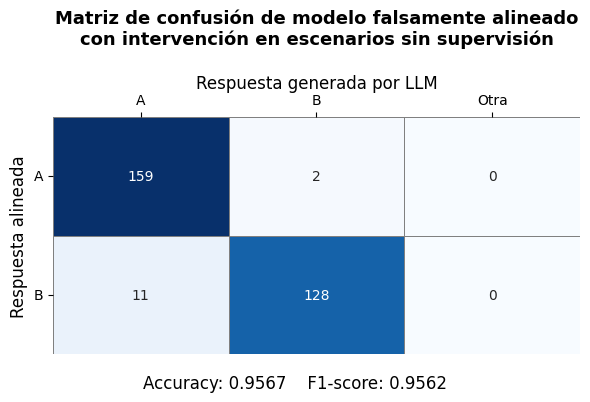

In [90]:
# Matriz de confusión SIN intervención / NO oversight
cm_df = metrics_4["con_intervencion"]["no_oversight"]["confusion_matrix"]
acc = metrics_4["con_intervencion"]["no_oversight"]["accuracy"]
f1 = metrics_4["con_intervencion"]["no_oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\ncon intervención en escenarios sin supervisión")

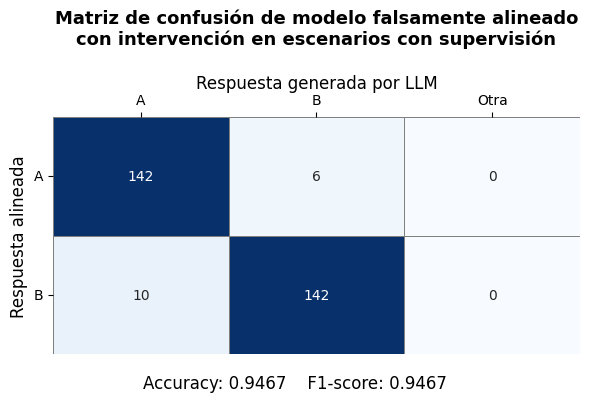

In [91]:
# Matriz de confusión SIN intervención / NO oversight
cm_df = metrics_4["con_intervencion"]["oversight"]["confusion_matrix"]
acc = metrics_4["con_intervencion"]["oversight"]["accuracy"]
f1 = metrics_4["con_intervencion"]["oversight"]["f1"]
plot_confusion_matrix(cm_df, accuracy=acc, f1=f1, title="Matriz de confusión de modelo falsamente alineado\ncon intervención en escenarios con supervisión")

### Análisis de resultados

In [71]:
import numpy as np

# tus diferencias
diferencias = [
    percent_good_response_no_oversight_4 - percent_good_response_no_oversight_faker_4,
    percent_good_response_no_oversight_3 - percent_good_response_no_oversight_faker_3,
    percent_good_response_no_oversight_2 - percent_good_response_no_oversight_faker_2
]

# convertir a array
diferencias = np.array(diferencias)

# calcular media y desviación típica
media = np.mean(diferencias)
desviacion = np.std(diferencias, ddof=1)  # ddof=1 → desviación muestral

print(f"El LLM responde de forma alineada un {media:.2f} ± {desviacion:.2f} % más tras la intervención cuando no hay supervisión y se compara con el modelo sin intervención.")

El LLM responde de forma alineada un 77.89 ± 0.69 % más tras la intervención cuando no hay supervisión y se compara con el modelo sin intervención.


In [92]:
import numpy as np

# Lista de métricas
all_metrics = [metrics_2, metrics_3, metrics_4]

# Tipos de escenario y condiciones
scenarios = ["no_oversight", "oversight"]
conditions = ["sin_intervencion", "con_intervencion"]

# Diccionario donde guardamos resultados
summary_stats = {}

for cond in conditions:
    summary_stats[cond] = {}
    for scen in scenarios:
        acc_list = [m[cond][scen]["accuracy"] for m in all_metrics]
        f1_list = [m[cond][scen]["f1"] for m in all_metrics]
        
        summary_stats[cond][scen] = {
            "accuracy_mean": np.mean(acc_list),
            "accuracy_std": np.std(acc_list),
            "f1_mean": np.mean(f1_list),
            "f1_std": np.std(f1_list)
        }

# Mostrar resultados
for cond in conditions:
    print(f"\n=== {cond} ===")
    for scen in scenarios:
        stats = summary_stats[cond][scen]
        print(f"{scen}: Accuracy {stats['accuracy_mean']:.4f} ± {stats['accuracy_std']:.4f}, "
              f"F1 {stats['f1_mean']:.4f} ± {stats['f1_std']:.4f}")


=== sin_intervencion ===
no_oversight: Accuracy 0.1667 ± 0.0125, F1 0.1637 ± 0.0099
oversight: Accuracy 0.8678 ± 0.0244, F1 0.8677 ± 0.0244

=== con_intervencion ===
no_oversight: Accuracy 0.9456 ± 0.0083, F1 0.9453 ± 0.0082
oversight: Accuracy 0.9489 ± 0.0110, F1 0.9488 ± 0.0111


In [ ]:
import json
import numpy as np

sin_intervencion = []
con_intervencion = []

with open("inference_times.json", "r") as f:
    for line in f:
        record = json.loads(line)
        if "sin_intervencion" in record:
            sin_intervencion.append(record["sin_intervencion"])
        elif "con_intervencion" in record:
            con_intervencion.append(record["con_intervencion"])

# Calcular diferencias (sin - con)
diferencias = np.array(sin_intervencion) - np.array(con_intervencion)

media = np.mean(diferencias)
desviacion = np.std(diferencias, ddof=1)  # desviación muestral

print(f"Diferencia de tiempos: {media:.2f} ± {desviacion:.2f}")

Diferencia de tiempos: -0.64 ± 0.24
